<a href="https://colab.research.google.com/github/michalcik10/SUNS_zadanie1_Steamhry/blob/main/zad3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers 
import tensorflow.keras.optimizers as optimizer
import matplotlib.pyplot as pl
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import plotly.figure_factory as ffc

from PIL import Image
from sklearn.pipeline import make_pipeline
from tensorflow.python.keras import backend as kb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

In [12]:
im_w =64 
im_h = 64
train_data_dir = '/content/drive/MyDrive/data-z3/train'
validation_data_dir = '/content/drive/MyDrive/data-z3/valid'
test_data_dir = '/content/drive/MyDrive/data-z3/test'
batch_size = 32

In [53]:
class_names = os.listdir(train_data_dir)
print(class_names)
print("Number of Classess:",len(class_names))

['giant slalom', 'snow boarding', 'lacrosse', 'surfing', 'bobsled', 'pole climbing', 'arm wrestling', 'golf', 'parallel bar', 'shuffleboard', 'baton twirling', 'uneven bars', 'pole vault', 'water cycling', 'roller derby', 'mushing', 'weightlifting', 'rowing', 'barell racing', 'hydroplane racing', 'field hockey', 'harness racing', 'football', 'canoe slamon', 'jousting', 'shot put', 'sidecar racing', 'disc golf', 'air hockey', 'sky surfing', 'motorcycle racing', 'baseball', 'ice yachting', 'ski jumping', 'cricket', 'horse racing', 'figure skating women', 'javelin', 'bowling', 'billiards', 'figure skating men', 'tug of war', 'horse jumping', 'basketball', 'frisbee', 'sumo wrestling', 'fly fishing', 'cheerleading', 'sailboat racing', 'bull riding', 'rock climbing', 'balance beam', 'polo', 'water polo', 'figure skating pairs', 'volleyball', 'rollerblade racing', 'high jump', 'hang gliding', 'formula 1 racing', 'hockey', 'table tennis', 'pommel horse', 'rugby', 'wingsuit flying', 'ampute foo

In [54]:
import cv2
for direct in class_names:
    im = cv2.imread(test_data_dir + '/' + direct + '/' + os.listdir(test_data_dir + '/' + direct)[0])
    #cv2_imshow(im)


In [55]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir, batch_size=batch_size, image_size=(im_w, im_h))

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_data_dir, batch_size=batch_size, image_size=(im_w, im_h))

# test_dataset = tf.keras.utils.image_dataset_from_directory(
#     test_data_dir, batch_size=batch_size, image_size=(im_w, im_h), shuffle=False)


Found 13619 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [36]:
print(train_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [71]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [72]:
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(im_w, im_h),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True,
    seed=123
)

Found 13619 images belonging to 100 classes.


In [73]:
validation_generator = train_datagen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(im_w, im_h),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True,
    seed=123
)

Found 500 images belonging to 100 classes.


In [74]:
test_generator = train_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(im_w, im_h),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False,
    seed=123
)

Found 500 images belonging to 100 classes.


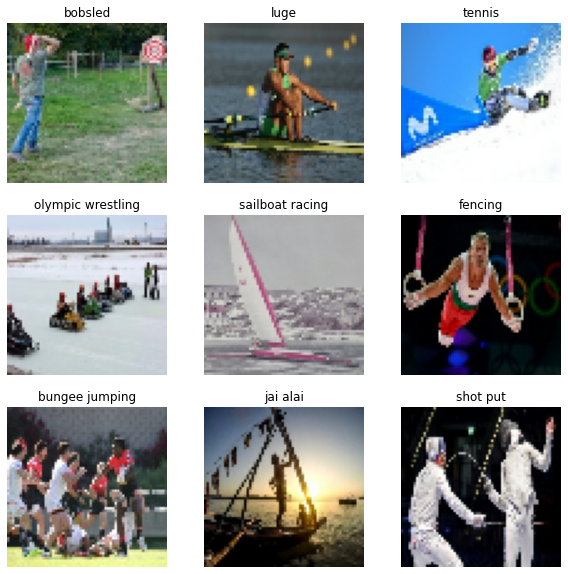

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(im_w, im_h, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       1

In [48]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=15)

Epoch 1/15
426/426 [==============================] - 189s 32ms/step - loss: 4.1738 - accuracy: 0.0648 - val_loss: 3.5403 - val_accuracy: 0.1780
Epoch 2/15
426/426 [==============================] - 2s 4ms/step - loss: 3.0763 - accuracy: 0.2392 - val_loss: 2.7088 - val_accuracy: 0.3060
Epoch 3/15
426/426 [==============================] - 2s 4ms/step - loss: 2.3859 - accuracy: 0.3817 - val_loss: 2.3094 - val_accuracy: 0.4180
Epoch 4/15
426/426 [==============================] - 2s 4ms/step - loss: 1.8977 - accuracy: 0.4952 - val_loss: 2.1925 - val_accuracy: 0.4200
Epoch 5/15
426/426 [==============================] - 2s 4ms/step - loss: 1.4345 - accuracy: 0.6144 - val_loss: 2.2816 - val_accuracy: 0.4440
Epoch 6/15
426/426 [==============================] - 2s 4ms/step - loss: 1.0273 - accuracy: 0.7152 - val_loss: 2.5301 - val_accuracy: 0.4100
Epoch 7/15
426/426 [==============================] - 2s 4ms/step - loss: 0.6602 - accuracy: 0.8089 - val_loss: 2.8867 - val_accuracy: 0.4200
Epo

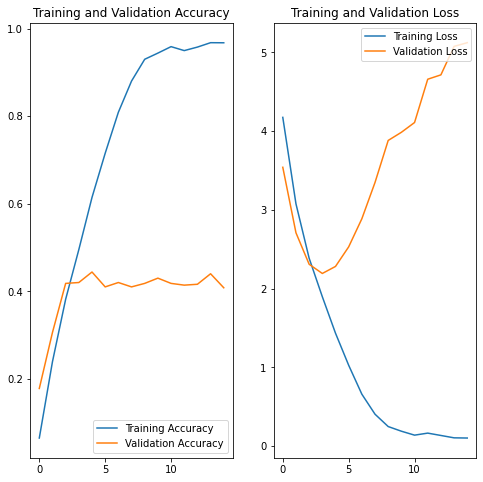

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

pl.figure(figsize=(8, 8))
pl.subplot(1, 2, 1)
pl.plot(epochs_range, acc, label='Training Accuracy')
pl.plot(epochs_range, val_acc, label='Validation Accuracy')
pl.legend(loc='lower right')
pl.title('Training and Validation Accuracy')

pl.subplot(1, 2, 2)
pl.plot(epochs_range, loss, label='Training Loss')
pl.plot(epochs_range, val_loss, label='Validation Loss')
pl.legend(loc='upper right')
pl.title('Training and Validation Loss')
pl.show()